# __Sentiment Analysis in Financial News: Text Classification on a Financial Phrasebank__

<h5 align="right">Shuang Zhang</h5> 

## **0. Introduction**

Investors are always interested in predicting stock price movements from financial news articles. Within the past several years, textual data in the financial domain is becoming increasingly important due to the progress in natural language processing (NLP). Various effective text mining models had been developed to extract valuable information from financial documents. However, the effectiveness of NLP models on finance-specific language and semantics is still a challenge for data scientists, because state-of-the-art models are seldom pre-trained on large-scale financial corpora. 

Sentiment analysis aims to determine the polarity of the source material, such as financial news, and assist good decision making. Sentiment analysis can be modelled as a classification problem. Two major use cases of sentiment analysis are subjectivity classification, i.e, labelling a sentence as objective or subjective, and polarity classification, i.e., labelling a sentence as expressing a positive, negative or neutral opinion. Common machine learning techniques could be applied to sentiment analysis. A  classifier is fed with text and returns the corresponding sentiment category. Text data needs to be transformed a numerical representation through feature extraction. Common feature extraction approaches include bag-of-words or bag-of-n-grams with their frequency and word vectors based on word embeddings. 

In this analysis, we test the performance of several machine learning algorithms and feature attraction approaches on a financial_phrasebank dataset, which covers a collection of 4840 sentences from financial news. All phrases were annotated by 16 financial professionals. The annotators were asked to consider the sentences from the view point of an investor and determine whether the news may have positive, negative or neutral influence on the stock price. The dataset comes from Huggingface dataset hub and we choose the sentences_75agree version, which includes the number of instances with >=75% annotator agreement. We first clean the raw data and perform exploratory data analysis, then convert the text data to numerical values based on five different feature attraction approaches. Finally, we train six machine learning models on the training data and evaluate their performance in predicting the sentiment of a piece of financial news.

Stakeholders involved:
- Investors: make data-based investment decisions
- Financial service providers: make real-time recommendations

## **1. Prepare the dataset**

In [1]:
## Import Libraries
from datasets import load_dataset

import numpy as np
import pandas as pd

import re
import string

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load dataset from Huggingface:

In [2]:
fin = load_dataset('financial_phrasebank','sentences_75agree')

Found cached dataset financial_phrasebank (C:/Users/dotie/.cache/huggingface/datasets/financial_phrasebank/sentences_75agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

- Dataset description:

The key arguments for the low utilization of statistical techniques in financial sentiment analysis have been the difficulty of implementation for practical applications and the lack of high quality training data for building such models. Especially in the case of finance and economic texts, annotated collections are a scarce resource and many are reserved for proprietary use only. To resolve the missing training data problem, we present a collection of ∼ 5000 sentences to establish human-annotated standards for benchmarking alternative modeling techniques.

The objective of the phrase level annotation task was to classify each example sentence into a positive, negative or neutral category by considering only the information explicitly available in the given sentence. Since the study is focused only on financial and economic domains, the annotators were asked to consider the sentences from the view point of an investor only; i.e. whether the news may have positive, negative or neutral influence on the stock price. As a result, sentences which have a sentiment that is not relevant from an
economic or financial perspective are considered neutral.

This release of the financial phrase bank covers a collection of **4840 sentences**. The selected collection of phrases was `annotated by 16 people with adequate background knowledge` on financial markets. Three of the annotators were researchers and the remaining 13 annotators were master’s students at Aalto University School of Business with majors primarily in finance, accounting, and economics.

Given the large number of overlapping annotations (5 to 8 annotations per sentence), there are several ways to define a majority vote based gold standard. To provide an objective comparison, we have formed 4 alternative reference datasets based on the strength of majority agreement: all annotators agree, >=75% of annotators agree, >=66% of annotators agree and >=50% of annotators agree.

The corpus used in this paper is made out of `English news` on all listed companies in `OMX Helsinki`. The news has been downloaded from the LexisNexis database using an automated web scraper. Out of this news database, a random subset of 10,000 articles was selected to obtain good coverage across small and large companies, companies in different industries, as well as different news sources. Following the approach taken by Maks and Vossen (2010), we excluded all sentences which did not contain any of the lexicon entities. This reduced the overall sample to 53,400 sentences, where each has at least one or more recognized lexicon entity. The sentences were then classified according to the types of entity sequences detected. Finally, a random sample of ∼5000 sentences was chosen to represent the overall news database.

Read the data into a dataframe:

In [3]:
df = pd.DataFrame(fin['train'], columns = ['sentence', 'label'])

In [4]:
df.head()

sentence  label
0  According to Gran , the company has no plans t...      1
1  With the new production plant the company woul...      2
2  For the last quarter of 2010 , Componenta 's n...      2
3  In the third quarter of 2010 , net sales incre...      2
4  Operating profit rose to EUR 13.1 mn from EUR ...      2

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3453 entries, 0 to 3452
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  3453 non-null   object
 1   label     3453 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 54.1+ KB


No missing values and the 'label' column is of the right data type.

This is a sample of different sentiments:

In [6]:
np.random.seed(53)
pd.set_option('display.max_colwidth', None)
df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=0.005))

sentence   
3413                                                                                                                       The net sales of the whole fiscal year 2008 will be lower than in 2007 and operating profit is estimated to be negative .  \
3311                                                                                                                             Insurer Axa ( PAR : CS ) slid by 5.35 % to EUR 14.15 , after Citigroup and ING slashed their targets on the stock .   
1361                                                                                                                                                                                             In 2005 the bank posted a net profit of Lt 8.2 mn .   
1721                                                                                                                                                            The company will be part of Teleste 's Video and Broadband Solutions business area .   
1628                                                                                                                                                                Latvia 's Stockmann shopping mall is a subsidiary of Finland 's Stockmann Plc. .   
2259                                                                                                                                                                    The maximum obligated total trades per day is ISK 400,000,000 market value .   
1894  Based on the design of previous handsets , the Nokia E72 and Nokia E63 this Symbian-based model is promised to offer direct access to over 90 per cent of the world s corporate email through Mail for Exchange and IBM Lotus Notes Traveler .   
2634                                                                                                                              Sampo Group that has become a major shareholder in Nordea owns TrygVesta 's main competitor , If P & C Insurance .   
2374                    These include software development for internet and mobile telephone content , communications , value-added software , financial services , security applications , systems integration and electronics , '' EBRD informed .   
1244                                                                                                                                                                            The use case dramatically narrows if you go only with the hot s Ltd.   
2958                                                                                                                                         `` Tweeple should check who 's following them , and be cautious when clicking on URLs and tinyurls . ''   
805               Aldata to Share Space Optimization Vision at Apollo User Group and 2009 Category Management Association Conferences ; Company Will Unveil New Solution that Combines Business Intelligence with Space Planning Data at Conferences   
1287                                                                                                                                                   Export accounts for about one tenth of the company 's annual turnover of one billion kroons .   
475                                  ADP News - Nov 13 , 2008 - Finnish printed circuit board PCB maker Aspocomp Group Oyj OMX : ACG1V said today that its net loss narrowed to EUR 2 million USD 2.5 m in the first nine months of 2008 from EUR 57   
174                                                           Svyturys-Utenos Alus , which is controlled by the Nordic group Baltic Beverages Holding ( BBH ) , posted a 4.7-per-cent growth in beer sales for January-May to 46.22 million litres .   
1193          Finland 's leading metals group Outokumpu said its fourth-quarter net profit more than tripled on the back of strong global demand for stainless steel , soaring base metal prices and proceeds from the sale of its technology unit .   
1255                

There are some extra whitespaces, e.g. the whitespaces before ` 's` and after `$ ` <br>
Check the distribution of labels:

In [7]:
df.label.value_counts()

label
1    2146
2     887
0     420
Name: count, dtype: int64

Cleansing the raw text, remove extra whitespaces and replace special characters with normal letters:

In [8]:
# check the distribution of special characters
check = df['sentence'].apply(lambda x:re.findall(r'[+|`|\n|\u4e00-\u9fff|\u00C0-\u00ff|\U00010000-\U0010ffff]', x))

In [9]:
print(check.sum())

['+', 'ñ', '+', 'ñ', '`', '`', '`', '`', '`', '`', '+', 'à', '+', 'ñ', '+', 'ñ', '+', 'ñ', '`', '`', '`', '`', '+', 'à', '+', 'ñ', '+', 'ñ', '+', 'à', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '+', 'ó', '`', '`', '+', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '+', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '+', 'ñ', '+', 'Â', '+', 'Ñ', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '+', 'à', '+', 'Ñ', '+', 'à', '+', 'Ñ', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '+', 'ñ', '+', 'Â', '+', '+', '+', 'á', 'á', '+', '+', '`', '`', '`', '`', '+', 'ñ', '+', 'ñ', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '+', '`', '`', '`', '`', '`', '`', '+', 'ä', '+', 'ñ', '`', '`', '+', '+', '+', 'ñ', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`', '`',

In [10]:
# Summarise the counts of special characters
specials = sorted(Counter(check.sum()).items())
print(specials)

[('+', 113), ('`', 319), ('Á', 2), ('Â', 8), ('Ñ', 6), ('à', 16), ('á', 4), ('ä', 4), ('é', 2), ('ñ', 43), ('ó', 9)]


In [11]:
# Remove extra whitespaces and replace special characters with normal letters
to_rep = [' \'s', '\$ ', ' %', '`', 'Á|Â', 'Ñ', 'à|ä|á|â', 'é', 'í', 'ñ', 'ó', 'ú']
rep_with = ['\'s', '$', '%', '', 'A', 'N', 'a', 'e', 'i', 'n', 'o', 'u']
df['sentence'] = df['sentence'].replace(to_rep, rep_with, regex=True)

## **2. Exploratory Data Analysis**

### 2.0 Word cloud

In [12]:
# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud

Prepare the text (The text of the entire dataset and subsets based on labels):

In [13]:
jointext = lambda x: ' '.join(e for e in x)

# Join the text of the entire dataset and subsets based on labels
inclu = jointext(df.sentence)
pos = jointext(df[df.label == 2].sentence)
neu = jointext(df[df.label == 1].sentence)
neg = jointext(df[df.label == 0].sentence)

Create word clouds for the entire dataset and three subsets based on labels:

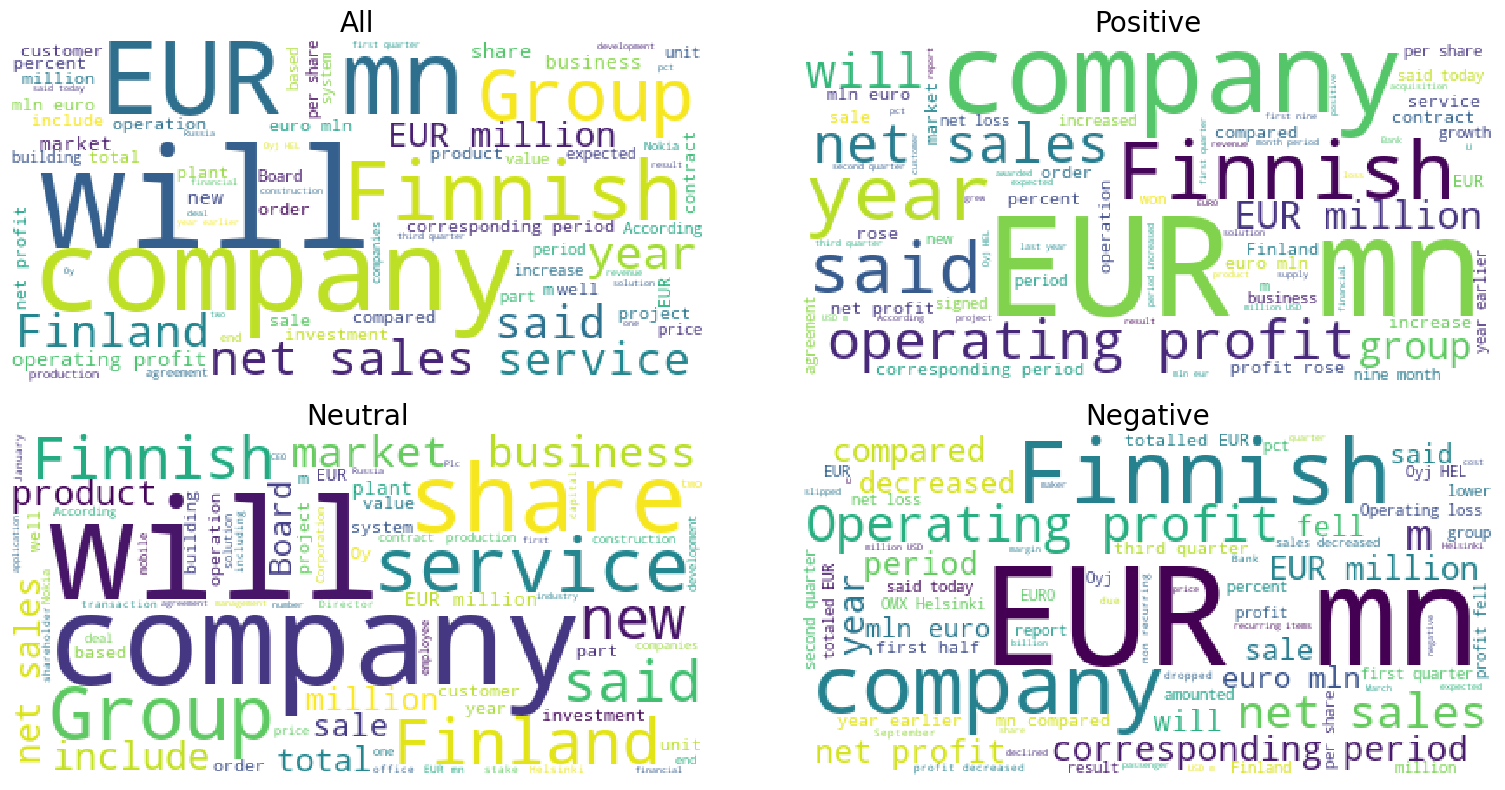

In [14]:
fig, axs = plt.subplots(2, 2, figsize = (16, 8))
for text, title, ax in zip([inclu, pos, neu, neg], ['All', 'Positive', 'Neutral', 'Negative'], axs.ravel()):
    wc = WordCloud(max_font_size=80, max_words=72, background_color="white").generate(text)
    ax.imshow(wc, interpolation='nearest')
    ax.set_title(title, fontsize=20)
    ax.axis('off')
plt.tight_layout();

plt.savefig('word_cloud.png')

### 2.1 Text-based features 

Create some text-based features:

Char_Count = Number of Characters in Text<br>
Word Count = Number of Words in Text<br>
Word Density = Average Number of Char in Words<br>
Punctuation Count = Number of Punctuation in Text<br>
Title Word Count = Number of Words in Title<br>
Uppercase Word Count = Number of Upperwords in Text

In [15]:
df['char_count'] = df['sentence'].apply(lambda x:len(x))
df['word_count'] = df['sentence'].apply(lambda x:len(x.split()))
df['punctuation_count'] = df['sentence'].apply(lambda x:len([c for c in x if c in [*set(string.punctuation)]]))
df['word_density'] = df['char_count']/(df['word_count']+1)
df['title_word_count'] = df['sentence'].apply(lambda x: len([w for w in x.split() if w.istitle()]))
df['uppercase_word_count'] = df['sentence'].apply(lambda x: len([w for w in x.split() if w.isupper()]))

In [16]:
# import and load spacy for NLP tasks
import spacy
nlp = spacy.load("en_core_web_md")

Count the number of adjective, adverb, noun, numeric, pronoun, proposition and verb:

In [17]:
%%time
# I feature's counts
count_cols = ['adj_count', 'adv_count', 'noun_count', 'num_count', 'pron_count', 'propn_count', 'verb_count']
pos_ls = ['ADJ', 'ADV', 'NOUN', 'NUM', 'PRON', 'PROPN', 'VERB']

for col, pos in zip(count_cols, pos_ls):
    df[col] = df['sentence'].apply(lambda x: len([t for t in list(nlp(x)) if t.pos_ == pos]))

CPU times: total: 3min 40s
Wall time: 3min 57s


Pairplot of text-based features:

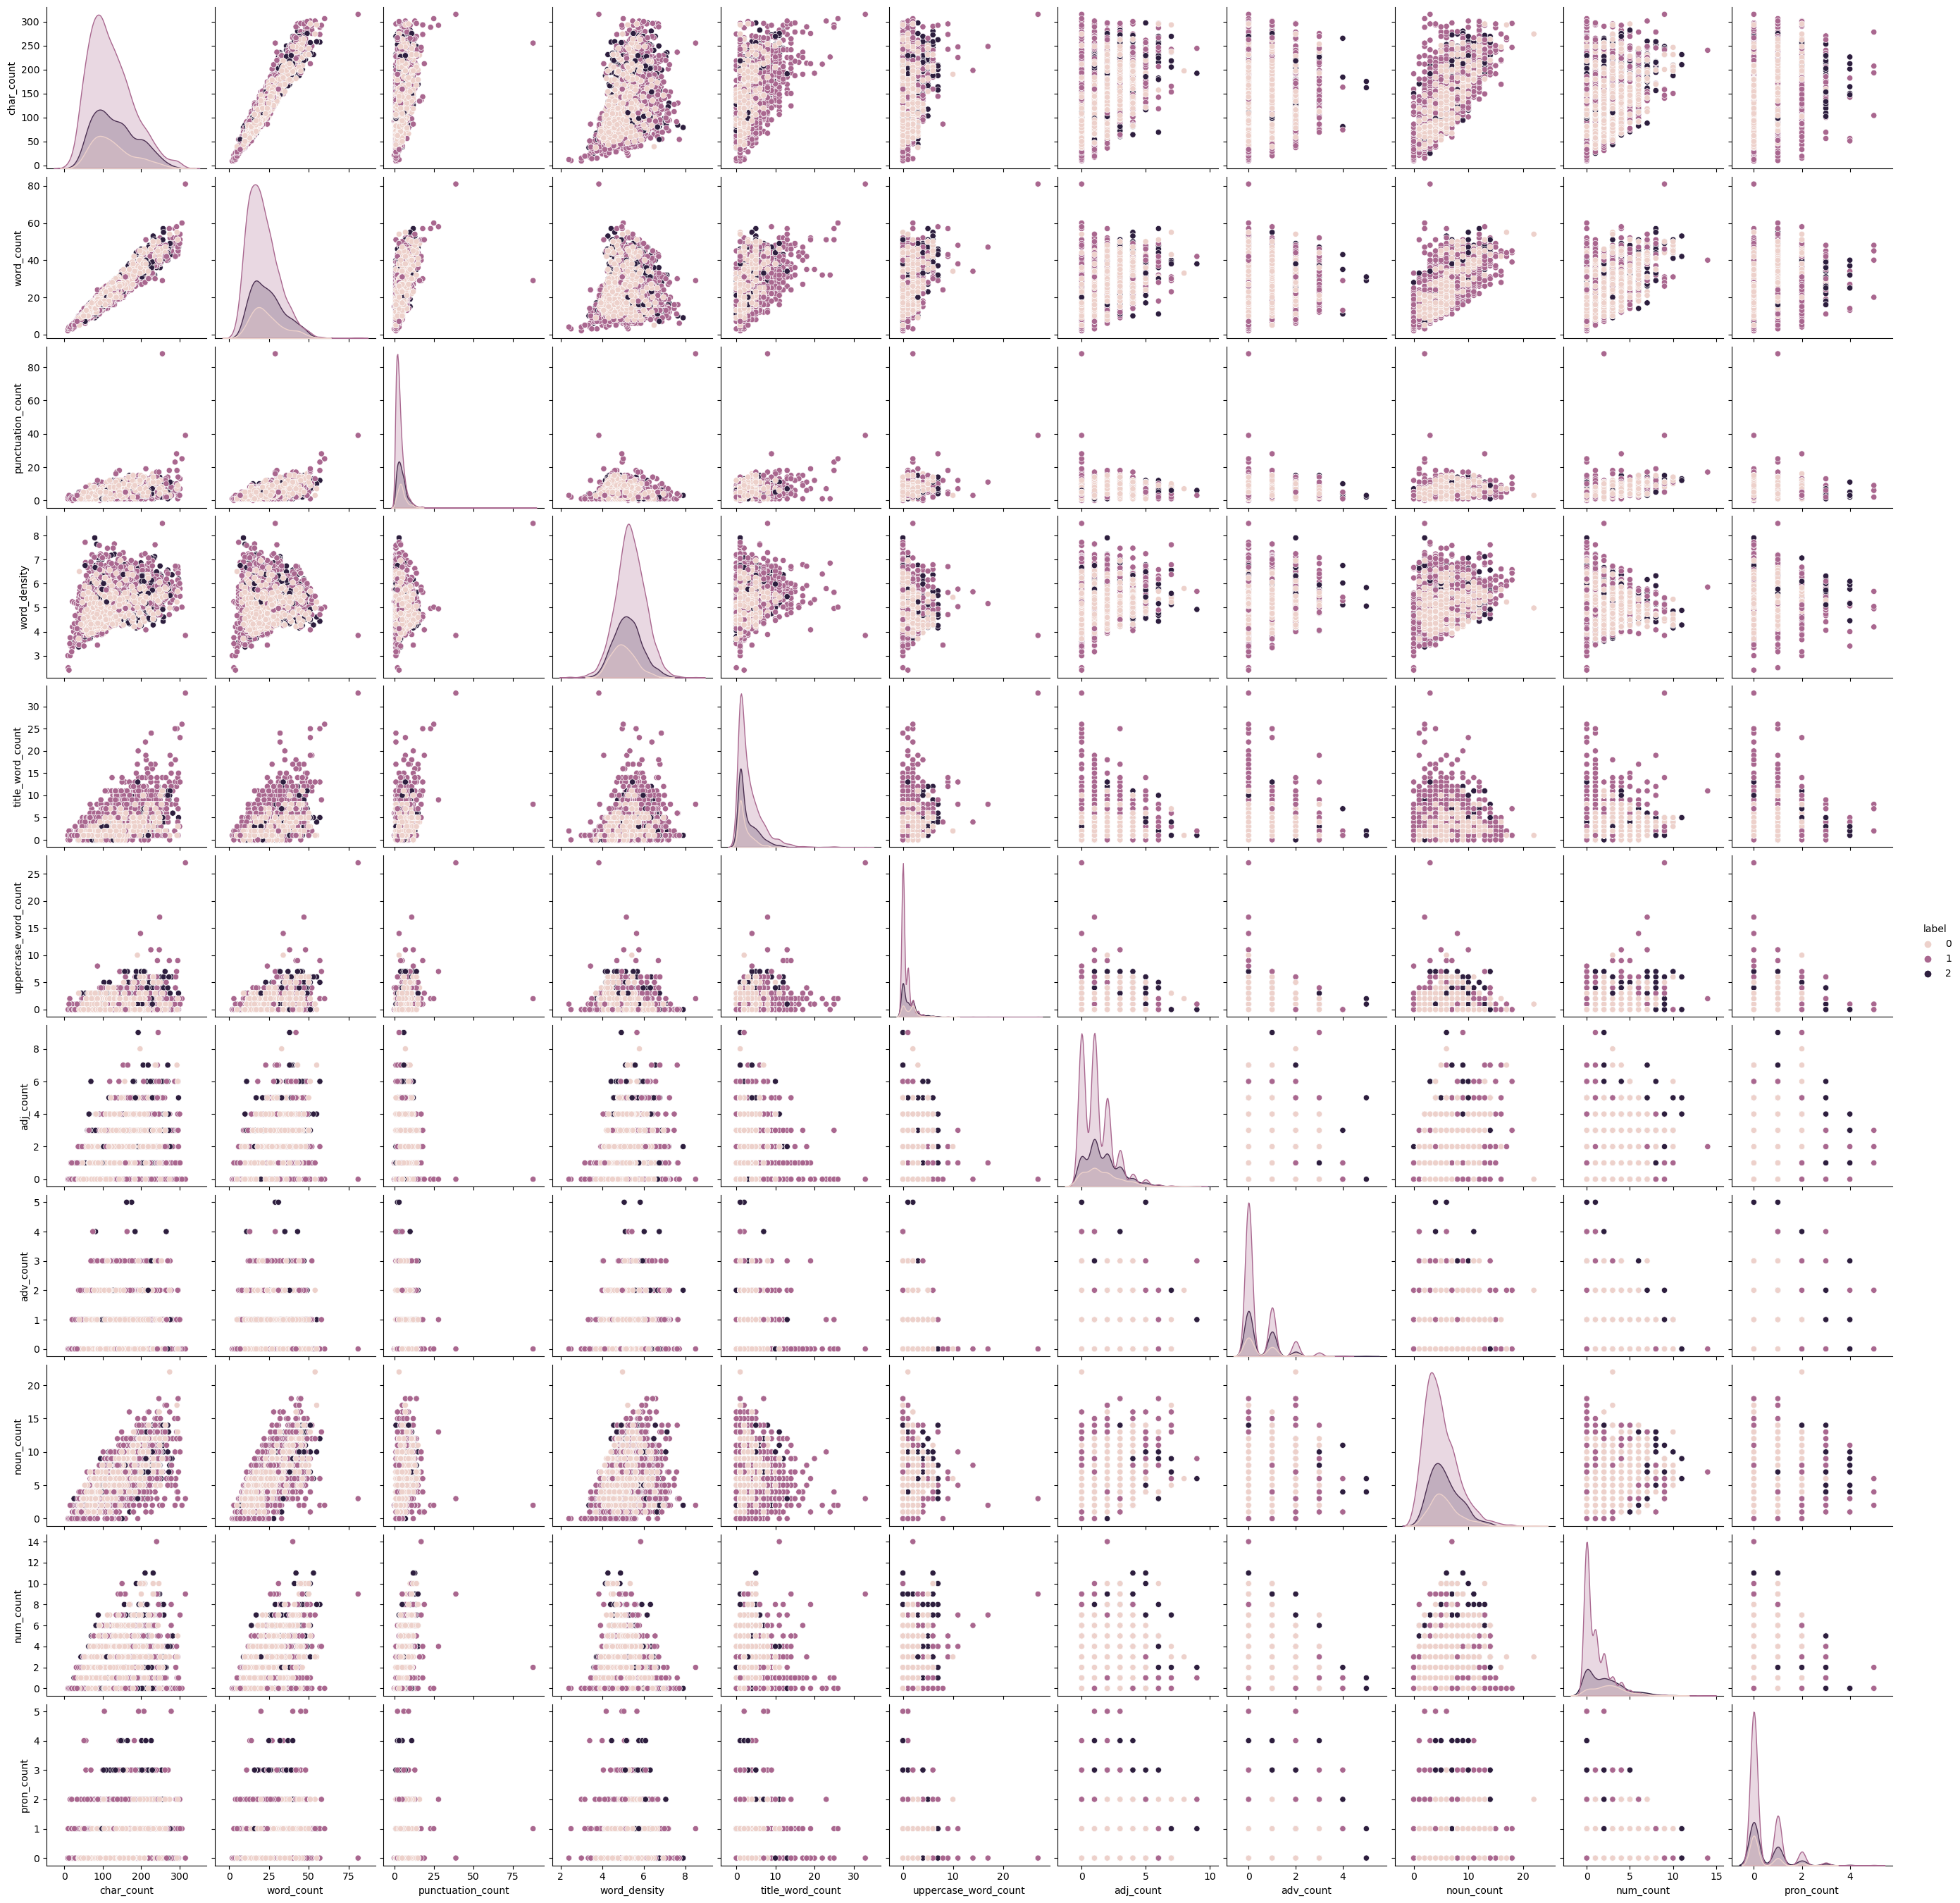

In [18]:
sns.pairplot(data = df.iloc[:,1:-2], hue = 'label');
plt.savefig('pair.png')

We can see that the text-based features generally do not give good cluster division.

### 2.2 Lemmatization

Lemmatize the text and remove stopwords and punctuations:

In [19]:
# Lemmatize the 'sentence' column and remove stopwords and punctuations:
df['lemma_ls']=df['sentence'].apply(lambda x: [t.lemma_ for t in list(nlp(x)) if (t.is_stop==False) and (t.is_punct == False)])

# Join the list of lemmas
df['lemmas'] = df['lemma_ls'].apply(lambda x: ' '.join([l for l in x]))
df[['sentence', 'label', 'lemmas']].head()

sentence   
0                                                                                 According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .  \
1  With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .   
2                For the last quarter of 2010 , Componenta's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .   
3                                                                                     In the third quarter of 2010 , net sales increased by 5.2% to EUR 205.5 mn , and operating profit by 34.9% to EUR 23.5 mn .   
4                                                                                       Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7% of net sales .   

   label   
0      1  \
1      2   
2      2   
3      2   
4      2   

                                                                                                                                  lemmas  
0                                                                                accord Gran company plan production Russia company grow  
1  new production plant company increase capacity meet expect increase demand improve use raw material increase production profitability  
2                quarter 2010 Componenta net sale double EUR131 m EUR76 m period year early move zero pre tax profit pre tax loss EUR7 m  
3                                                      quarter 2010 net sale increase 5.2 EUR 205.5 mn operating profit 34.9 EUR 23.5 mn  
4                                            operate profit rise EUR 13.1 mn EUR 8.7 mn corresponding period 2007 represent 7.7 net sale

### 2.3 Topic modelling using Latent Dirichlet allocation (LDA)

In [20]:
# Import library
from gensim import corpora, models

Prepare objects for LDA gensim implementation:

In [21]:
dictionary_LDA = corpora.Dictionary(df['lemma_ls'])
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(lemmas) for lemmas in df['lemma_ls']]

Run the LDA model:

In [22]:
num_topics = 12
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=4, \
                                  alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary_LDA.keys()))

Print out the 12 topics:

In [23]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(i)+": "+ topic)
    #print()

0: 0.030*"company" + 0.024*"Finland" + 0.016*"say" + 0.011*"term" + 0.010*"expect" + 0.009*"concern" + 0.009*"level" + 0.009*"manufacture" + 0.008*"remain" + 0.008*"communication"
1: 0.024*"company" + 0.015*"market" + 0.015*"include" + 0.013*"operation" + 0.012*"line" + 0.010*"plant" + 0.010*"manage" + 0.009*"equipment" + 0.009*"situation" + 0.008*"Finland"
2: 0.049*"$" + 0.042*"mln" + 0.040*"million" + 0.035*"euro" + 0.023*"company" + 0.020*"approximately" + 0.019*"sale" + 0.017*"net" + 0.015*"billion" + 0.014*"2007"
3: 0.033*"market" + 0.032*"value" + 0.027*"company" + 0.019*"order" + 0.017*"say" + 0.015*"product" + 0.015*" " + 0.012*"development" + 0.010*"Bank" + 0.010*"include"
4: 0.025*"million" + 0.016*"market" + 0.016*"percent" + 0.016*"year" + 0.016*"Finland" + 0.013*"contract" + 0.012*"EUR" + 0.010*"sale" + 0.009*"say" + 0.009*"volume"
5: 0.087*"EUR" + 0.058*"mn" + 0.043*"profit" + 0.036*"net" + 0.035*"m" + 0.031*"sale" + 0.027*"quarter" + 0.026*"period" + 0.025*"year" + 0.022

Visualise the topics:

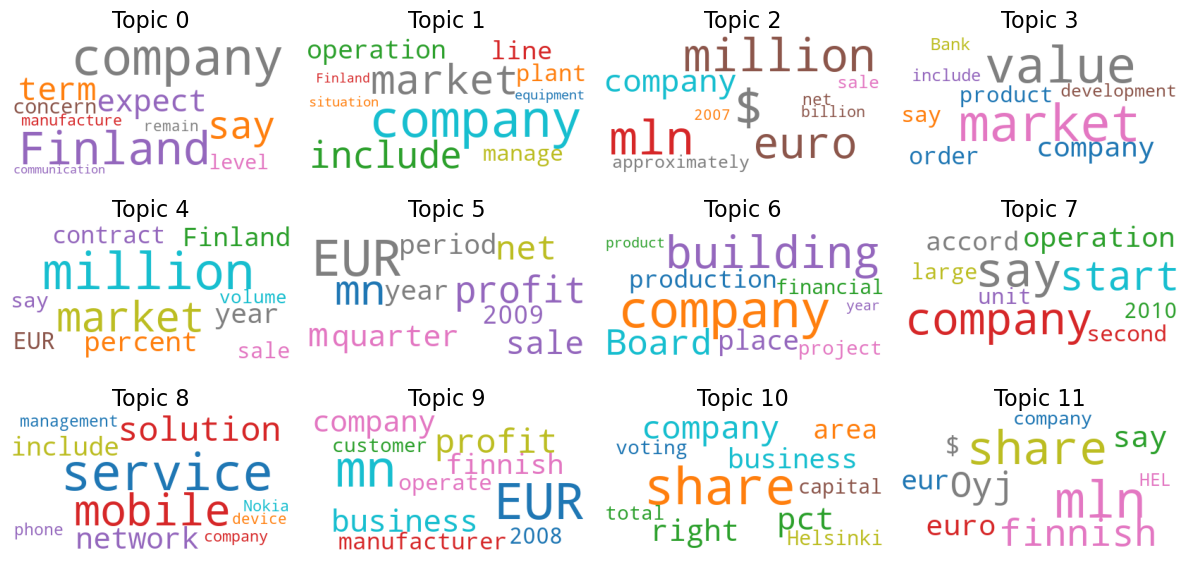

In [24]:
fig, axs = plt.subplots(3, 4, figsize = (12, 6), sharex=True, sharey=True)

cloud = WordCloud(background_color='white',
                  max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_topics=num_topics, num_words=10)

for i, ax in enumerate(axs.flatten()):
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=72)
    ax.imshow(cloud)
    ax.set_title('Topic ' + str(i), fontdict=dict(size=16))
    ax.axis('off')

plt.tight_layout();
plt.savefig('topic.png')

Topics are not easily distinguishable based on the top 10 words.

Allocation of topics in all sentences:

In [25]:
topic_ls = [lda_model[corpus[i]] for i in range(len(df))]

In [26]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

In [27]:
document_topic = pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topic_ls]).reset_index(drop=True).fillna(0)

Distribution of topics in the dataset:

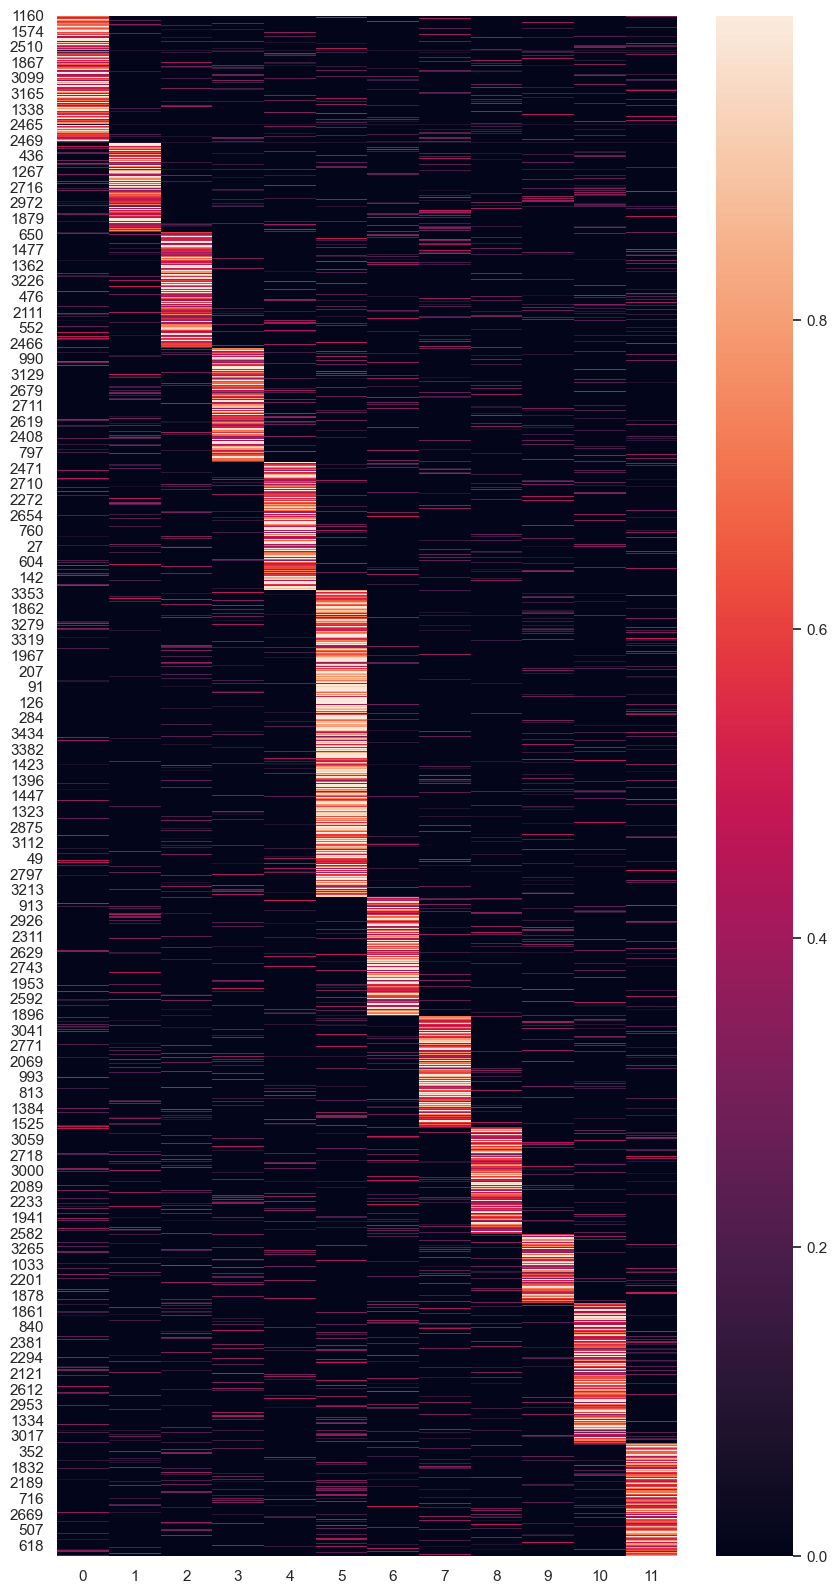

In [28]:
sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index]);

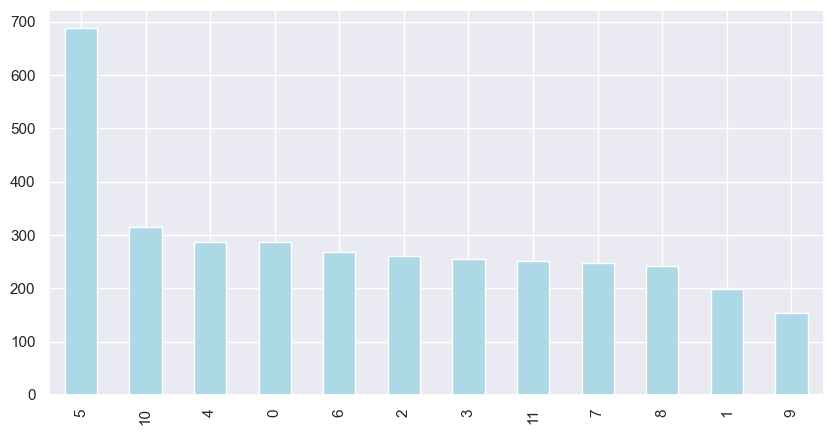

In [29]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue');

Topic 5 seems to be the most popular topic among all documents.

## **3. Feature Extraction**

The raw text data needs to be transformed into flat features that can be fed into machine learning models.

Five approaches are used to transform text data:
- **Text/NLP based features:** the features generated in 2.1<br>
Character count, word count, word density, punctuation count, title word count, uppercase word count, part-of-speech count
- **Count vectors as features:**  aka Bag of Words (BoW)<br>
The frequency count of a particular word in a particular document
- **TF-IDF (Term Frequency–Inverse Document Frequency) vectors as features:** also a bag of word vectorization<br>
The relative importance of a term in the document and the entire corpus.Increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word.<br>
**Word level**: Matrix of TF-IDF scores of every single word in different documents.<br>
**N-gram level**: Matrix of TF-IDF scores of N words together
- **Word Embeddings as features:** based on the surrounding words<br>
Generated using Word2Vec(a pretrained word embeddings)

In [30]:
# Imoport library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### 3.0 Train-test split

In [31]:
X = df.iloc[:,2:]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### 3.1 Text-based features

In [32]:
scaler = StandardScaler()

# Select the text-based features and apply standardscaler
X_train_cs = scaler.fit_transform(X_train.iloc[:,:-2])
X_test_cs = scaler.transform(X_test.iloc[:,:-2])

### 3.2 Count Vectors as features

In [33]:
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

count_vect.fit(X['lemmas'])

X_train_count = count_vect.transform(X_train['lemmas']).toarray()
X_test_count = count_vect.transform(X_test['lemmas']).toarray()

### 3.3 Tf-idf Vectors as features

a. Word level tf-idf

In [34]:
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
tfidf_vect.fit(X['lemmas'])
X_train_tfidf = tfidf_vect.transform(X_train['lemmas']).toarray()
X_test_tfidf = tfidf_vect.transform(X_test['lemmas']).toarray()

b. Ngram level tf-idf

In [35]:
tfidf_vect_ng = TfidfVectorizer(analyzer = 'word',
                                token_pattern = r'\w{1,}',
                                ngram_range = (2, 3),
                                max_features = 5000)

tfidf_vect_ng.fit(X['lemmas'])
X_train_tfidf_ng = tfidf_vect_ng.transform(X_train['lemmas']).toarray()
X_test_tfidf_ng = tfidf_vect_ng.transform(X_test['lemmas']).toarray()

### 3.4 Word embeddings as features

In [36]:
# word2vec model
w2v_mdl = models.Word2Vec(df['lemma_ls'], vector_size=100, window=5, min_count=1, workers=4)

In [37]:
def vectorize(ts):
    word_vecs = [w2v_mdl.wv[t] for t in ts if t in w2v_mdl.wv]
    if len(word_vecs) == 0:
        return np.zeros(100)
    word_vecs = np.array(word_vecs)
    return word_vecs.mean(axis = 0)

In [38]:
X_train_w2v = np.array(X_train['lemma_ls'].apply(lambda x: vectorize(x)).tolist())
X_test_w2v = np.array(X_test['lemma_ls'].apply(lambda x: vectorize(x)).tolist())

## **4. Model Performance**

Six classification algorithms are tested:
- **Logistic Regression:** computing the probability of a discrete outcome given an input variable
- **Naive Bayes:** computing the conditional a posterior probabilities of a class variable of a given independent predictor variable
- **k Nearest Neighbors:** classifying objects based on their proximate neighbors’ classes
- **Decision Tree:** classifying samples by sorting them down the tree
- **Random Forest:** an ensemble method, made up of a multitude of decision trees, the output is the class selected by most trees
- **Gradient Boosting:** an ensemble method, combines many weak learners together to create a strong predictive model

In [39]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, f1_score

### 4.0 Training models

Keep the results in a dataframe:

In [40]:
scores = pd.DataFrame(columns = ['vector', 'classifier', 'accuracy', 'f1'])

Classifiers and feature vectors:

In [41]:
classifiers = [LogisticRegression(solver = 'sag', max_iter = 350), 
               GaussianNB(), 
               KNeighborsClassifier(4), 
               DecisionTreeClassifier(max_depth=4), 
               RandomForestClassifier(),
               GradientBoostingClassifier()]
clf_names = ['Logistic Regression', 'Naive Bayes', 'k-Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
feature_vectors_train = [X_train_cs, X_train_count, X_train_tfidf, X_train_tfidf_ng, X_train_w2v]
feature_vectors_test = [X_test_cs, X_test_count, X_test_tfidf, X_test_tfidf_ng, X_test_w2v]
vec_names = ['Text-based', 'Count', 'TF-IDF Word', 'TF-IDF Ngram', 'Word2Vec']

Loop over classifiers and feature vectors, record the accuracy and f1-score of each model:

In [42]:
%%time
for clf, name in zip(classifiers, clf_names):
    for train, test, vec in zip(feature_vectors_train, feature_vectors_test, vec_names):
        clf.fit(train, y_train)
        y_pred = clf.predict(test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(name + ' ' + vec + ' ' + 'Accuracy: ' + str(accuracy) + ' '  + 'f1: ' + str(f1))
        result = {'vector': vec, 'classifier': name, 'accuracy': accuracy, 'f1': f1}
        scores.loc[len(scores)] = result

Logistic Regression Text-based Accuracy: 0.6525096525096525 f1: 0.5937088855148339
Logistic Regression Count Accuracy: 0.8243243243243243 f1: 0.8177763644019251
Logistic Regression TF-IDF Word Accuracy: 0.7915057915057915 f1: 0.773080097076645
Logistic Regression TF-IDF Ngram Accuracy: 0.7181467181467182 f1: 0.6671863930268961
Logistic Regression Word2Vec Accuracy: 0.6505791505791506 f1: 0.5785275367889593
Naive Bayes Text-based Accuracy: 0.6264478764478765 f1: 0.6078714631913225
Naive Bayes Count Accuracy: 0.6515444015444015 f1: 0.6578338886329894
Naive Bayes TF-IDF Word Accuracy: 0.638996138996139 f1: 0.6428455792280867
Naive Bayes TF-IDF Ngram Accuracy: 0.5299227799227799 f1: 0.5676668605941109
Naive Bayes Word2Vec Accuracy: 0.5106177606177607 f1: 0.5274493324740992
k-Nearest Neighbors Text-based Accuracy: 0.6361003861003861 f1: 0.6130874630716454
k-Nearest Neighbors Count Accuracy: 0.7027027027027027 f1: 0.6469804210445388
k-Nearest Neighbors TF-IDF Word Accuracy: 0.649613899613899

### 4.1 Comparing different models

In [43]:
scores = scores.round(4)
scores

vector           classifier  accuracy      f1
0     Text-based  Logistic Regression    0.6525  0.5937
1          Count  Logistic Regression    0.8243  0.8178
2    TF-IDF Word  Logistic Regression    0.7915  0.7731
3   TF-IDF Ngram  Logistic Regression    0.7181  0.6672
4       Word2Vec  Logistic Regression    0.6506  0.5785
5     Text-based          Naive Bayes    0.6264  0.6079
6          Count          Naive Bayes    0.6515  0.6578
7    TF-IDF Word          Naive Bayes    0.6390  0.6428
8   TF-IDF Ngram          Naive Bayes    0.5299  0.5677
9       Word2Vec          Naive Bayes    0.5106  0.5274
10    Text-based  k-Nearest Neighbors    0.6361  0.6131
11         Count  k-Nearest Neighbors    0.7027  0.6470
12   TF-IDF Word  k-Nearest Neighbors    0.6496  0.5523
13  TF-IDF Ngram  k-Nearest Neighbors    0.6168  0.4806
14      Word2Vec  k-Nearest Neighbors    0.6264  0.6064
15    Text-based        Decision Tree    0.6612  0.5903
16         Count        Decision Tree    0.7143  0.6735
17   TF-IDF Word        Decision Tree    0.7085  0.6600
18  TF-IDF Ngram        Decision Tree    0.6544  0.5792
19      Word2Vec        Decision Tree    0.6351  0.5713
20    Text-based        Random Forest    0.6979  0.6562
21         Count        Random Forest    0.8137  0.7989
22   TF-IDF Word        Random Forest    0.8079  0.7917
23  TF-IDF Ngram        Random Forest    0.7394  0.7137
24      Word2Vec        Random Forest    0.6670  0.6228
25    Text-based    Gradient Boosting    0.6757  0.6315
26         Count    Gradient Boosting    0.8359  0.8264
27   TF-IDF Word    Gradient Boosting    0.8282  0.8179
28  TF-IDF Ngram    Gradient Boosting    0.7394  0.6994
29      Word2Vec    Gradient Boosting    0.6737  0.6366

#### 4.1.1 Accuracy 

In [44]:
acc_scores = scores.pivot(index = 'vector', columns='classifier', values='accuracy')
acc_scores = acc_scores[clf_names].reindex(vec_names)
acc_scores

classifier    Logistic Regression  Naive Bayes  k-Nearest Neighbors   
vector                                                                
Text-based                 0.6525       0.6264               0.6361  \
Count                      0.8243       0.6515               0.7027   
TF-IDF Word                0.7915       0.6390               0.6496   
TF-IDF Ngram               0.7181       0.5299               0.6168   
Word2Vec                   0.6506       0.5106               0.6264   

classifier    Decision Tree  Random Forest  Gradient Boosting  
vector                                                         
Text-based           0.6612         0.6979             0.6757  
Count                0.7143         0.8137             0.8359  
TF-IDF Word          0.7085         0.8079             0.8282  
TF-IDF Ngram         0.6544         0.7394             0.7394  
Word2Vec             0.6351         0.6670             0.6737

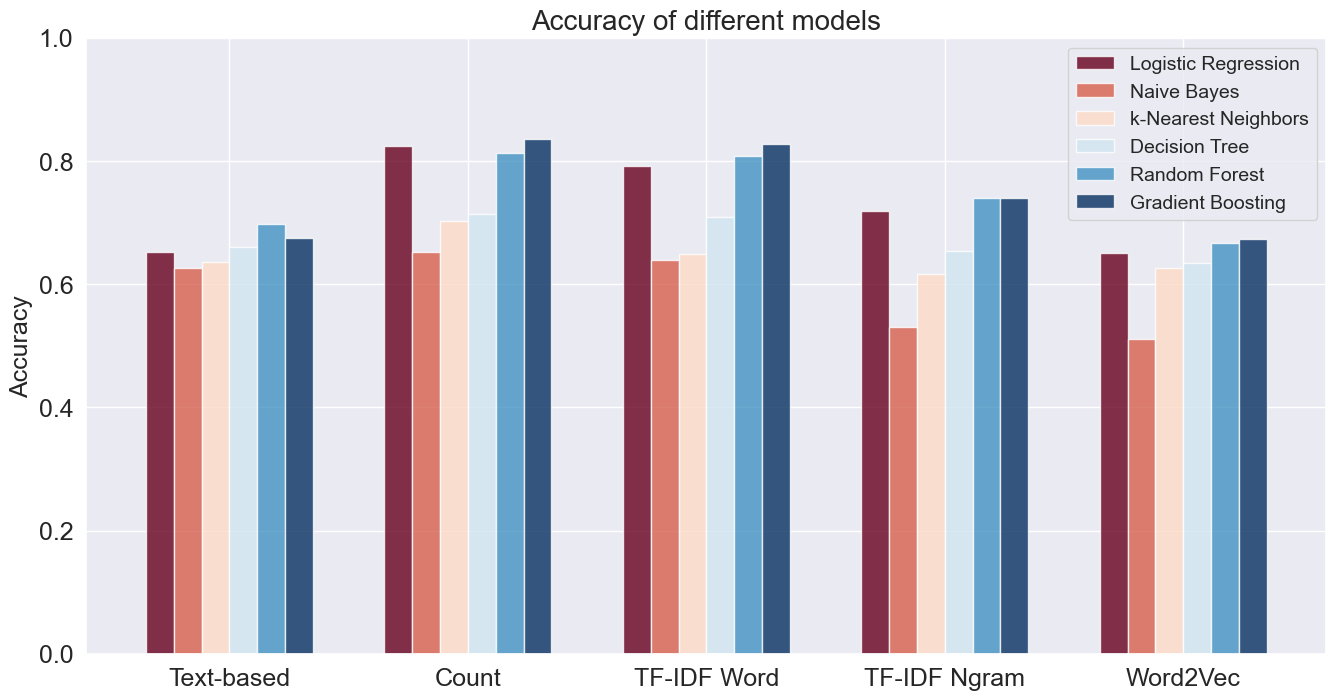

In [45]:
# plot the results
acc_scores.plot.bar(figsize=(16,8), ylim = [0, 1], alpha=0.8, width = 0.7, fontsize = 18, colormap='RdBu', rot=0)
plt.xlabel('')
plt.ylabel('Accuracy', fontsize=18)
plt.title('Accuracy of different models', fontsize=20)
plt.legend(clf_names, loc ="upper right", fontsize=14);
plt.savefig('acc_scores.png')

- Model performance based on accuracy:

In terms of feature extraction approaches, the features created by `CountVectorizer` and `word-level TfidfVectorizer` outperform other features. `CountVectorizer` is a notch above word-level TfidfVectorizer. `Text-based features` and `word embedding features` perform poorly with accuracy scores no higher than the baseline accuracy.

Word embedding features are expected to work more effectively than other feature extraction approaches, such as bag of words methods, because word embedding helps extract information based on the surrounding words, thereby providing more relevant and important patterns to the model to tackle the underlying problem. But word embedding does not perform well in this case. The reason might be we have to take average of the Word2Vec embeddings of the words in each sentence and information could be lost in the averaging.

With regards to classification algorithms, the two ensemble methods, namely, `GradientBoostingClassifier` and `RandomForestClassifier`, achieve best accuracy scores. The scores of `logistic regression` are generally slightly lower than those of ensemble method, but way above the scores of Naive Bayes, k Nearest Neighbors and Decision Tree.

Top 3 models:<br> 
  **1. GradientBoosting + CountVectorizer**<br>
  **2. GradientBoosting + TfidfVectorizer**<br>
  **3. LogisticRegression + CountVectorizer**

#### 4.1.2 Weighted average f1 score

In [46]:
f1_scores = scores.pivot(index = 'vector', columns='classifier', values='f1')
f1_scores = f1_scores[clf_names].reindex(vec_names)
f1_scores

classifier    Logistic Regression  Naive Bayes  k-Nearest Neighbors   
vector                                                                
Text-based                 0.5937       0.6079               0.6131  \
Count                      0.8178       0.6578               0.6470   
TF-IDF Word                0.7731       0.6428               0.5523   
TF-IDF Ngram               0.6672       0.5677               0.4806   
Word2Vec                   0.5785       0.5274               0.6064   

classifier    Decision Tree  Random Forest  Gradient Boosting  
vector                                                         
Text-based           0.5903         0.6562             0.6315  
Count                0.6735         0.7989             0.8264  
TF-IDF Word          0.6600         0.7917             0.8179  
TF-IDF Ngram         0.5792         0.7137             0.6994  
Word2Vec             0.5713         0.6228             0.6366

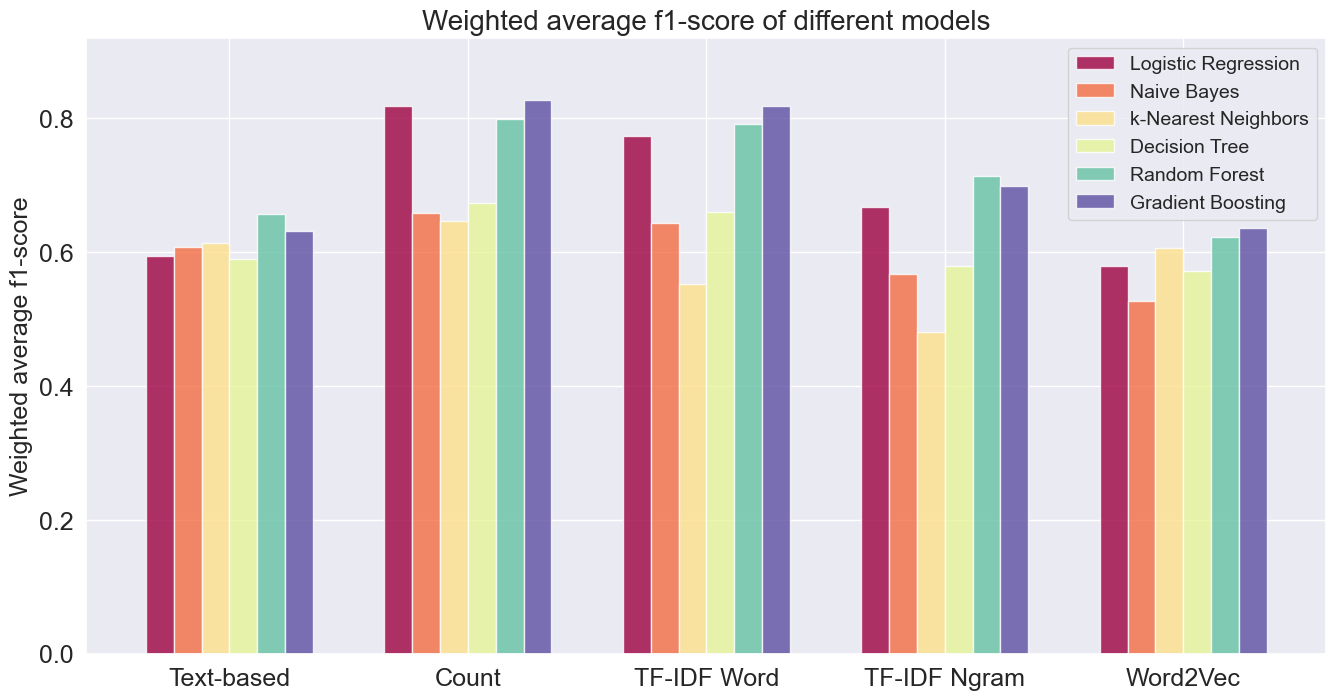

In [47]:
f1_scores.plot.bar(figsize=(16,8), ylim = [0, 0.92], alpha=0.8, width = 0.7, fontsize = 18, colormap='Spectral', rot=0)
plt.xlabel('')
plt.ylabel('Weighted average f1-score', fontsize=18)
plt.title('Weighted average f1-score of different models', fontsize=20)
plt.legend(clf_names, loc ="upper right", fontsize=14);
plt.savefig('f1_scores.png')

- Model performance based on weighted average f1-score:

The ranking of performance is the same as the rankings based on accuracy. 

Feature extraction approaches: CountVectorizer, word-level TfidfVectorizer > ngram-level TfidfVectorizer >>   Word embedding features, Text-based features

Classifiers:  GradientBoostingClassifier, RandomForestClassifier > Logistic regression >>  Decision Tree, k Nearest Neighbors, Naive Bayes

Top 3 models:<br> 
  **1. GradientBoosting + CountVectorizer**<br>
  **2. GradientBoosting + TfidfVectorizer**<br>
  **3. LogisticRegression + CountVectorizer**

### 4.2 Try neural network

In [48]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical

Convert the target to categorical:

In [49]:
y_train_cat = to_categorical(y_train, num_classes = 3, dtype = 'uint8')
y_test_cat = to_categorical(y_test, num_classes = 3, dtype = 'uint8')

Set up the model architecture:

In [50]:
model = Sequential(
    [# Add the first hidden layer
        Dense(50, activation = 'relu', input_shape = (X_train_count.shape[1], )),
    # Add the second hidden layer
        Dense(20, activation = 'relu'),
    # Add the output layer
        Dense(3, activation = 'softmax')]
)

In [51]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                339700    
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 3)                 63        
                                                                 
Total params: 340,783
Trainable params: 340,783
Non-trainable params: 0
_________________________________________________________________
None


Compile the model:

In [52]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

Fit the model:

In [53]:
%%time
history = model.fit(
    X_train_count,
    y_train_cat,
    validation_split = 0.25,
    batch_size = 200,
    epochs = 30,
    verbose = 1)

Epoch 1/30
10/10 [==============================] - 1s 49ms/step - loss: 1.0640 - accuracy: 0.5756 - val_loss: 1.0054 - val_accuracy: 0.6893
Epoch 2/30
10/10 [==============================] - 0s 20ms/step - loss: 0.9299 - accuracy: 0.7417 - val_loss: 0.9002 - val_accuracy: 0.7025
Epoch 3/30
10/10 [==============================] - 0s 21ms/step - loss: 0.7825 - accuracy: 0.7655 - val_loss: 0.7919 - val_accuracy: 0.7140
Epoch 4/30
10/10 [==============================] - 0s 20ms/step - loss: 0.6304 - accuracy: 0.8079 - val_loss: 0.6989 - val_accuracy: 0.7223
Epoch 5/30
10/10 [==============================] - 0s 21ms/step - loss: 0.4923 - accuracy: 0.8642 - val_loss: 0.6240 - val_accuracy: 0.7686
Epoch 6/30
10/10 [==============================] - 0s 20ms/step - loss: 0.3811 - accuracy: 0.9150 - val_loss: 0.5771 - val_accuracy: 0.7835
Epoch 7/30
10/10 [==============================] - 0s 20ms/step - loss: 0.2909 - accuracy: 0.9443 - val_loss: 0.5499 - val_accuracy: 0.7851
Epoch 8/30
10

Make predictions:

In [54]:
pred = np.argmax(model.predict(X_test_count), axis=-1)

33/33 [==============================] - 0s 3ms/step


Model accuracy:

In [55]:
score = model.evaluate(X_test_count, y_test_cat, batch_size = 500)
print('\nTest loss: %.6f, Test accuracy: %.6f' % tuple(score))

3/3 [==============================] - 0s 9ms/step - loss: 0.8216 - accuracy: 0.7847

Test loss: 0.821580, Test accuracy: 0.784749


Plot training & validation accuracy/loss:

In [56]:
hist = pd.DataFrame(history.history)
hist.tail()

loss  accuracy  val_loss  val_accuracy
25  0.010672       1.0  0.654595      0.808264
26  0.009596       1.0  0.669946      0.801653
27  0.008819       1.0  0.675165      0.806612
28  0.008036       1.0  0.680367      0.808264
29  0.007392       1.0  0.690976      0.804959

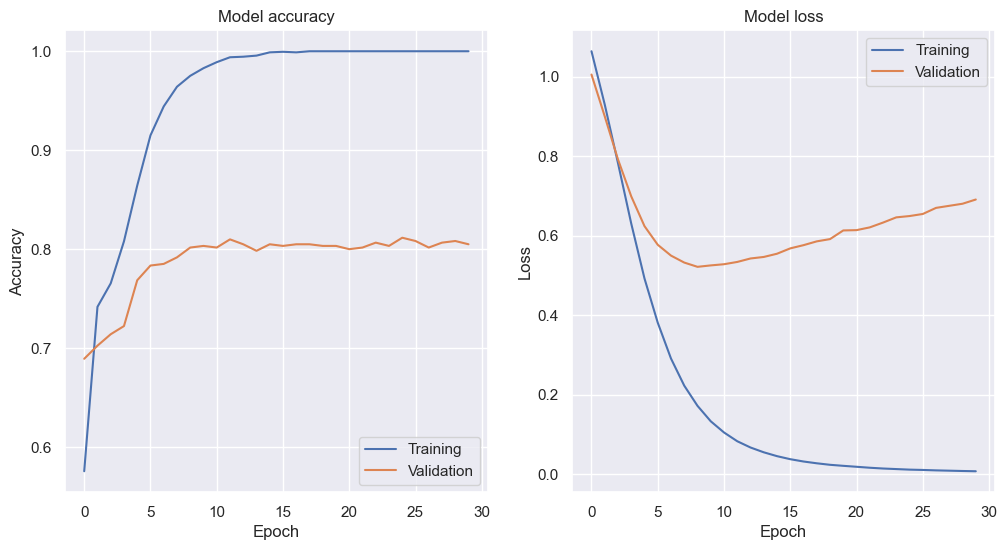

In [57]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

# Plot training & validation accuracy values
ax[0].plot(hist['accuracy'], label = 'Training')
ax[0].plot(hist['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# Plot training & validation loss values
ax[1].plot(hist['loss'], label = 'Training')
ax[1].plot(hist['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend();

plt.savefig('nn.png')

The neural network model fails to achieve a higher accuracy. The model loss reaches the minimum and starts to increase at the 10th epoch, indicating that the model becomes overfitting at an early stage.

### 4.3 Further evaluation: class-wise performance of top 3 models

In [58]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay 

**1. GradientBoostingClassifier + CountVectorier**

Fit the model:

In [59]:
%%time
gb_clf_count = GradientBoostingClassifier()
gb_clf_count.fit(X_train_count, y_train)

CPU times: total: 3min 26s
Wall time: 3min 39s


GradientBoostingClassifier()

In [60]:
# Function to plot confusion matrix
def conf_plot(conf):
    sns.set(rc={'figure.figsize':(6,6)})
    sns.heatmap(conf, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'RdPu', annot_kws={"size": 18})
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

Confusion matrix:

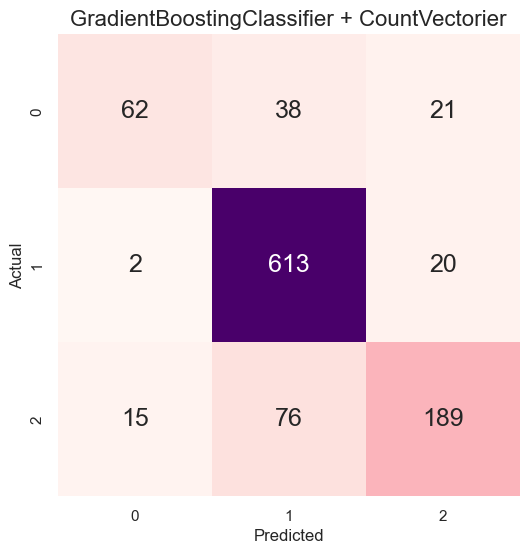

In [61]:
y_pred_gb_count = gb_clf_count.predict(X_test_count)
gb_count_conf = confusion_matrix(y_test, y_pred_gb_count)
conf_plot(gb_count_conf)
plt.title('GradientBoostingClassifier + CountVectorier', fontsize=16);
plt.savefig('gb_count_conf.png')

Classification report:

In [62]:
# Function to convert classification_report to dataframe
def clf_rp_df(clf_rp_dict):
    df = pd.DataFrame(columns = ['class', 'precision', 'recall', 'f1', 'support'])
    for name in ['0', '1', '2']:
        result = {'class': name, 
                  'precision': clf_rp_dict[name]['precision'], 
                  'recall': clf_rp_dict[name]['recall'],
                  'f1': clf_rp_dict[name]['f1-score'],
                  'support': clf_rp_dict[name]['support']}
        df.loc[len(df)] = result
    return df

In [63]:
clf_rp_gb_count = classification_report(y_test, y_pred_gb_count, output_dict = True)
clf_df_gb_count = clf_rp_df(clf_rp_gb_count).round(4)
clf_df_gb_count

class  precision  recall      f1  support
0     0     0.7848  0.5124  0.6200      121
1     1     0.8432  0.9654  0.9001      635
2     2     0.8217  0.6750  0.7412      280

One-vs-rest receiver operating characteristic (ROC) curve:

Binarize labels in a one-vs-all fashion:

In [64]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

In [65]:
# Function to plot one-vs-rest ROC curve
def ovr_roc_curve(y_predpro): 
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)
    class_names = ['Negative', 'Neutral', 'Postive']
    colors = ['C0', 'C1', 'C2']

    for i in np.arange(3):
        RocCurveDisplay.from_predictions(y_onehot_test[:, i], y_predpro[:, i], name=f"{class_names[i]} vs the rest", color=colors[i], ax=ax[i])
        ax[i].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
        ax[i].axis('square')
        ax[i].set_xlabel('False Positive Rate')
        ax[i].set_ylabel('True Positive Rate')
        ax[i].legend(loc='lower right')
        ax[i].set_title(f"One-vs-Rest ROC curves:\nClass: {i}")

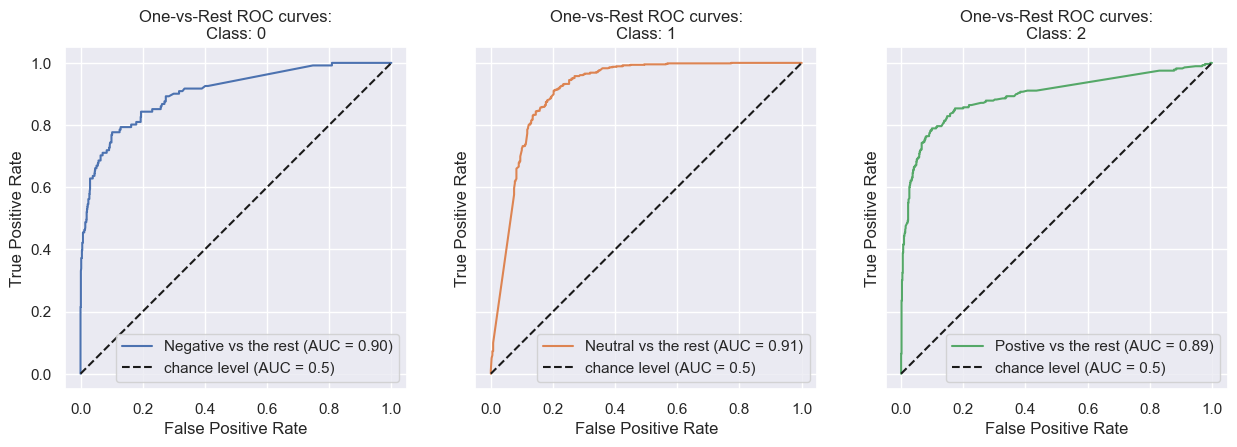

In [66]:
y_predpro_gb_count = gb_clf_count.predict_proba(X_test_count)
ovr_roc_curve(y_predpro_gb_count)
plt.savefig('gb_count_roc.png')

**2. GradientBoostingClassifier + TfidfVectorier(Word)**

Fit the model:

In [67]:
%%time
gb_clf_tfidf = GradientBoostingClassifier()
gb_clf_tfidf.fit(X_train_tfidf, y_train)

CPU times: total: 2min 35s
Wall time: 2min 46s


GradientBoostingClassifier()

Confusion matrix:

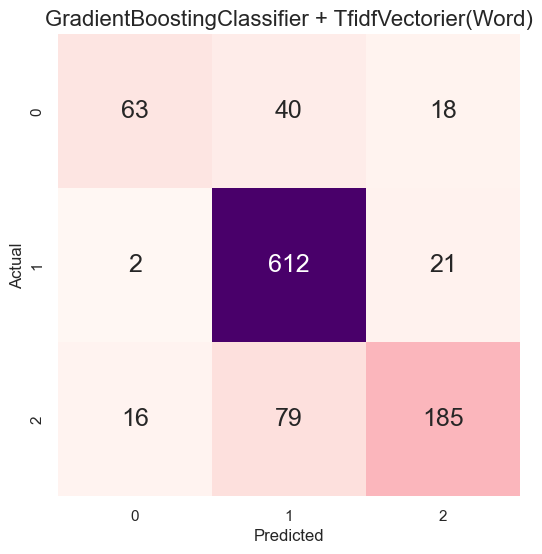

In [68]:
y_pred_gb_tfidf = gb_clf_tfidf.predict(X_test_tfidf)
gb_tfidf_conf = confusion_matrix(y_test, y_pred_gb_tfidf)
conf_plot(gb_tfidf_conf)
plt.title('GradientBoostingClassifier + TfidfVectorier(Word)', fontsize=16);
plt.savefig('gb_tfidf_conf.png')

Classification report:

In [69]:
clf_rp_gb_tfidf = classification_report(y_test, y_pred_gb_tfidf, output_dict = True)
clf_df_gb_tfidf = clf_rp_df(clf_rp_gb_tfidf).round(4)
clf_df_gb_tfidf

class  precision  recall      f1  support
0     0     0.7778  0.5207  0.6238      121
1     1     0.8372  0.9638  0.8960      635
2     2     0.8259  0.6607  0.7341      280

One-vs-rest receiver operating characteristic (ROC) curve:

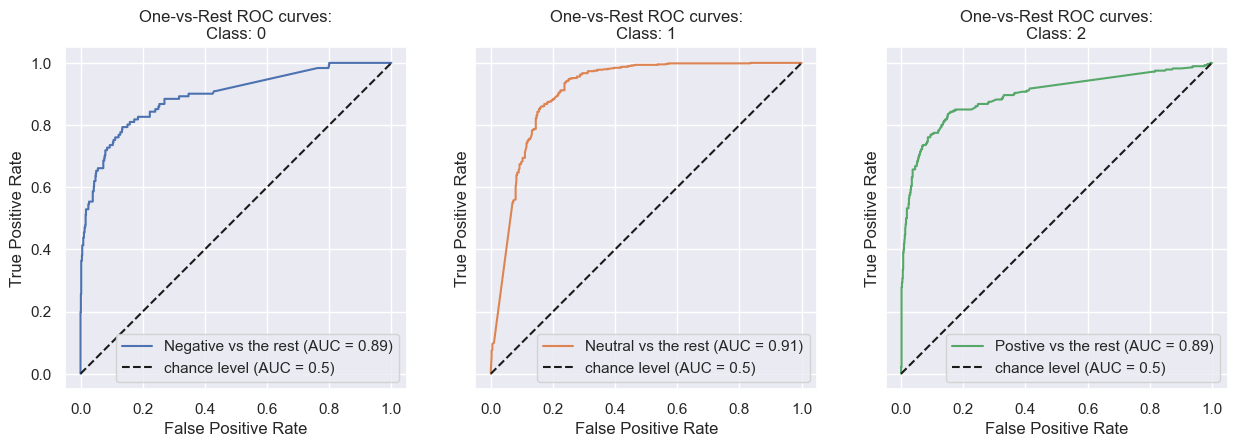

In [70]:
y_predpro_gb_tfidf = gb_clf_tfidf.predict_proba(X_test_tfidf)
ovr_roc_curve(y_predpro_gb_tfidf)
plt.savefig('gb_tfidf_roc.png')

**3. LogisticRegression + CountVectorier**

Grid search for optimal parameters:

In [71]:
lr_params = {
    'clf__C': [0.1, 1, 10]
}

In [72]:
%%time
X_in = X['lemmas']
lr = Pipeline([('vec', CountVectorizer(token_pattern = r'\w{1,}')), ('clf', LogisticRegression(solver = 'sag', max_iter = 350))])
GS_lr = GridSearchCV(lr, lr_params, cv=3, n_jobs=-1)
GS_lr.fit(X_in, y)

CPU times: total: 703 ms
Wall time: 7.57 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vec',
                                        CountVectorizer(token_pattern='\\w{1,}')),
                                       ('clf',
                                        LogisticRegression(max_iter=350,
                                                           solver='sag'))]),
             n_jobs=-1, param_grid={'clf__C': [0.1, 1, 10]})

In [73]:
print("The parameter setting that gave the best results is:", GS_lr.best_params_)
print("The mean cross-validated score of the best_estimator is:", GS_lr.best_score_)

The parameter setting that gave the best results is: {'clf__C': 1}
The mean cross-validated score of the best_estimator is: 0.7657109759629307


Fit the model:

In [74]:
%%time
lr = LogisticRegression(solver = 'sag', max_iter = 350)
lr.fit(X_train_count, y_train)

CPU times: total: 22.2 s
Wall time: 24 s


LogisticRegression(max_iter=350, solver='sag')

Confusion Matrics:

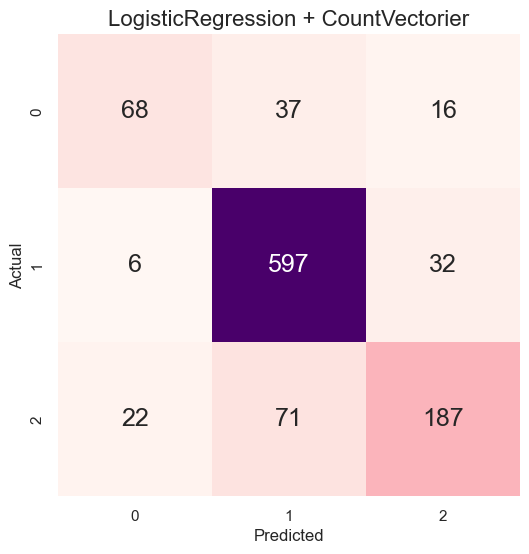

In [75]:
y_pred_lr = lr.predict(X_test_count)
conf_lr = confusion_matrix(y_test, y_pred_lr)
conf_plot(conf_lr)
plt.title('LogisticRegression + CountVectorier', fontsize=16)
plt.savefig('conf_lr.png')

Classification report:

In [76]:
clf_rp_lr = classification_report(y_test, y_pred_lr, output_dict = True)
clf_df_lr = clf_rp_df(clf_rp_lr).round(4)
clf_df_lr

class  precision  recall      f1  support
0     0     0.7083  0.5620  0.6267      121
1     1     0.8468  0.9402  0.8910      635
2     2     0.7957  0.6679  0.7262      280

One-vs-rest receiver operating characteristic (ROC) curve:

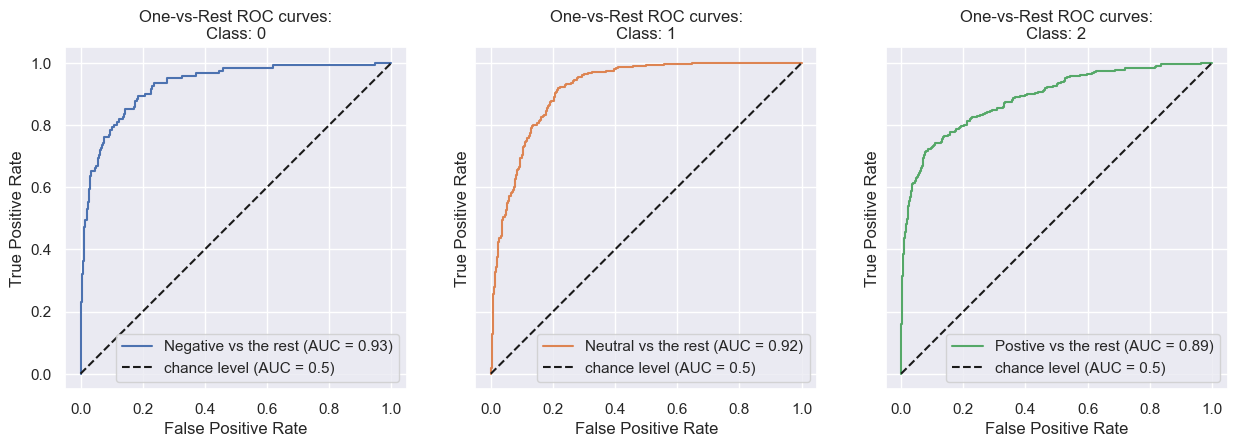

In [77]:
y_predpro_lr = lr.predict_proba(X_test_count)
ovr_roc_curve(y_predpro_lr)
plt.savefig('lr_roc.png')

Based on the confusion matrices, class-wise precision/recall scores and one-vs-all ROC curves, GradientBoostingClassifier tends to yield better results for class 2 as compared with logistic regression, while the logistic regression model has the most correctly classified class 0 cases and the highest recall and ROC AUC score for class 0.

Summarise the results:

In [78]:
with pd.option_context('mode.chained_assignment', None):
    columns = ['class', 'precision', 'recall']
    df_gb_count = clf_df_gb_tfidf[columns]
    df_gb_count['model'] = 'GradientBoosting_CountVectorizer'
    df_gb_count['roc_auc'] = roc_auc_score(y_test, y_predpro_gb_count, multi_class = 'ovr', average = None)
    df_gb_tfidf = clf_df_gb_tfidf[columns]
    df_gb_tfidf['model'] = 'GradientBoosting_TfidfVectorizer'
    df_gb_tfidf['roc_auc'] = roc_auc_score(y_test, y_predpro_gb_tfidf, multi_class = 'ovr', average = None)
    df_lr = clf_df_lr[columns]
    df_lr['model'] = 'LogisticRegression_CountVectorizer'
    df_lr['roc_auc'] = roc_auc_score(y_test, y_predpro_lr, multi_class = 'ovr', average = None)
    df_scores = pd.concat([df_gb_count, df_gb_tfidf, df_lr])
df_scores

class  precision  recall                               model   roc_auc
0     0     0.7778  0.5207    GradientBoosting_CountVectorizer  0.904159
1     1     0.8372  0.9638    GradientBoosting_CountVectorizer  0.912757
2     2     0.8259  0.6607    GradientBoosting_CountVectorizer  0.893915
0     0     0.7778  0.5207    GradientBoosting_TfidfVectorizer  0.893059
1     1     0.8372  0.9638    GradientBoosting_TfidfVectorizer  0.909050
2     2     0.8259  0.6607    GradientBoosting_TfidfVectorizer  0.894208
0     0     0.7083  0.5620  LogisticRegression_CountVectorizer  0.928582
1     1     0.8468  0.9402  LogisticRegression_CountVectorizer  0.917360
2     2     0.7957  0.6679  LogisticRegression_CountVectorizer  0.887467

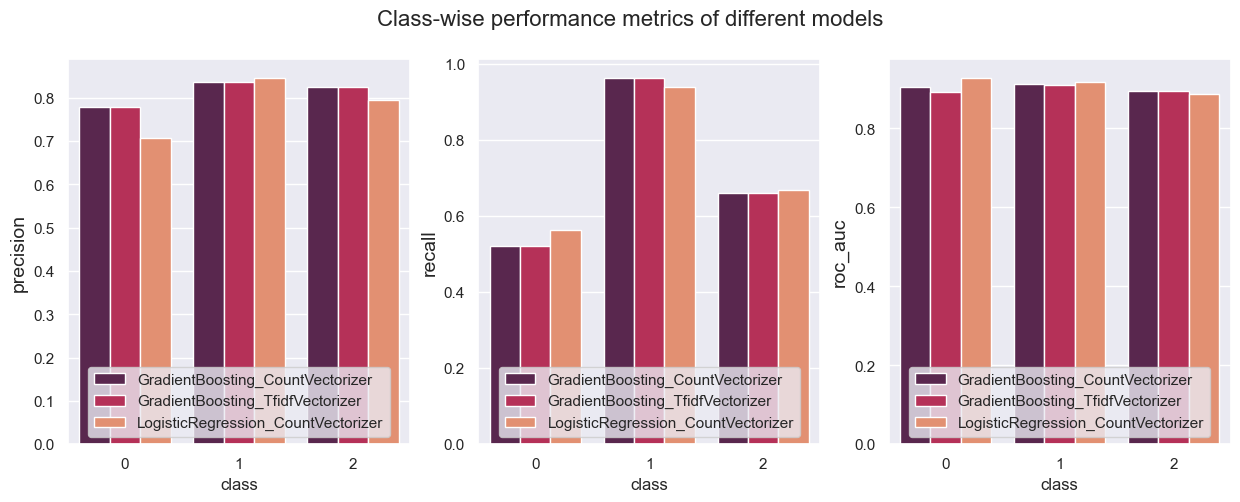

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
scores = ['precision', 'recall', 'roc_auc']
for score, ax in zip(scores, axs.ravel()):
    sns.barplot(data=df_scores, x='class', y=score, hue='model', palette = 'rocket', ax=ax)
    ax.legend(loc='lower center')
    ax.set_ylabel(score, fontsize=14)
plt.suptitle('Class-wise performance metrics of different models', fontsize = 16)
plt.savefig('classwise.png');

The class-wise performance metrics of the top 3 models have no essential difference. Gradient boosting models generally have better precision scores, but the logistic regression model has higher recall score for class 0 and overall higher ROC AUC scores. If we take time efficiency into consideration, logistic regression is more recommendable as the execution time of logistic regression is significantly shorter than that of gradient boosting method. 

## 5. Conclusion

In this analysis, we performed a text classification task on `financial_phrase` bank dataset, aiming to identify the sentiments of financial news. We implemented five feature extraction appoaches and six classification algorithms. In total 30 models were created from the combination of different feature vectors and machine learning classifiers.

Among all feature extraction approaches, CountVectorizer and word-level TfidfVectorizer outperform other approaches, with CountVectorizer being the best performer. The performance of text-based features and word embedding features is less than satisfaction. 

The two ensemble methods, namely, GradientBoostingClassifier and RandomForestClassifier, outperform other classifiers, but the performance of logistic regression is just slightly lower than the ensemble methods. These three classifiers perform much better than Naive Bayes, k Nearest Neighbors and Decision Tree.

The top 3 models are:
1. GradientBoosting + CountVectorizer
2. GradientBoosting + TfidfVectorizer
3. LogisticRegression + CountVectorizer

The class-wise performance metrics of the top 3 models have little difference, and logistic regression is more recommendable than ensemble methods in terms of execution time. 